In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2021-04-05 19:03:30--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.01s   

2021-04-05 19:03:30 (5.85 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



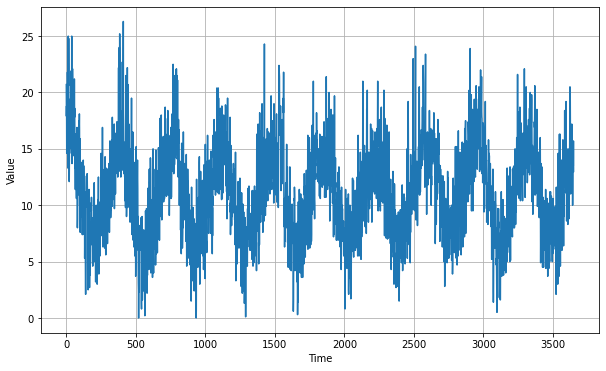

In [13]:
import csv
time_step = []
temps = []
counter = 0

with open('/tmp/daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(int(counter))
    counter +=1
# YOUR CODE HERE. READ TEMPERATURES INTO TEMPS
# HAVE TIME STEPS BE A SIMPLE ARRAY OF 1, 2, 3, 4 etc

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [14]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [15]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [16]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder = True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [17]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [19]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters = 32, kernel_size=5, strides=1, padding='causal', activation='relu', input_shape=[None,1]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
        tf.keras.layers.Dense(30, activation='relu'),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x * 400)

])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 35s 41ms/step - loss: 21.0075 - mae: 21.5054
Epoch 2/100
10/10 [==============================] - 1s 39ms/step - loss: 19.7809 - mae: 20.2786
Epoch 3/100
10/10 [==============================] - 1s 39ms/step - loss: 17.9388 - mae: 18.4360
Epoch 4/100
10/10 [==============================] - 1s 38ms/step - loss: 15.9328 - mae: 16.4294
Epoch 5/100
10/10 [==============================] - 1s 39ms/step - loss: 13.8870 - mae: 14.3828
Epoch 6/100
10/10 [==============================] - 1s 42ms/step - loss: 11.9245 - mae: 12.4186
Epoch 7/100
10/10 [==============================] - 1s 39ms/step - loss: 10.1961 - mae: 10.6884
Epoch 8/100
10/10 [==============================] - 0s 37ms/step - loss: 8.9995 - mae: 9.4900
Epoch 9/100
10/10 [==============================] - 1s 37ms/step - loss: 8.2376 - mae: 8.7257
Epoch 10/100
10/10 [========

(1e-08, 0.0001, 0.0, 60.0)

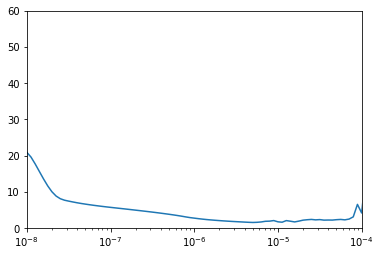

In [20]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [30]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters = 30, kernel_size=5, strides=1, padding='causal', activation='relu', input_shape=[None,1]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(60, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(60, return_sequences=True)),
        tf.keras.layers.Dense(30, activation='relu'),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x * 400)

])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=30)
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/30
25/25 [==============================] - 6s 24ms/step - loss: 33.1584 - mae: 33.6533
Epoch 2/30
25/25 [==============================] - 1s 22ms/step - loss: 4.0604 - mae: 4.5359
Epoch 3/30
25/25 [==============================] - 1s 21ms/step - loss: 1.7637 - mae: 2.2139
Epoch 4/30
25/25 [==============================] - 1s 22ms/step - loss: 1.4739 - mae: 1.9167
Epoch 5/30
25/25 [==============================] - 1s 22ms/step - loss: 1.3672 - mae: 1.8063
Epoch 6/30
25/25 [==============================] - 1s 24ms/step - loss: 1.2879 - mae: 1.7233
Epoch 7/30
25/25 [==============================] - 1s 23ms/step - loss: 1.2418 - mae: 1.6760
Epoch 8/30
25/25 [==============================] - 1s 24ms/step - loss: 1.2028 - mae: 1.6351
Epoch 9/30
25/25 [==============================] - 1s 23ms/step - loss: 1.1814 - mae: 1.6130
Epoch 10/30
25/25 [==============================] - 1s 22ms/step - loss: 1.1586 - mae: 1.5888
Epoch 11/30
25/25 [==============================] - 1s 2

In [31]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

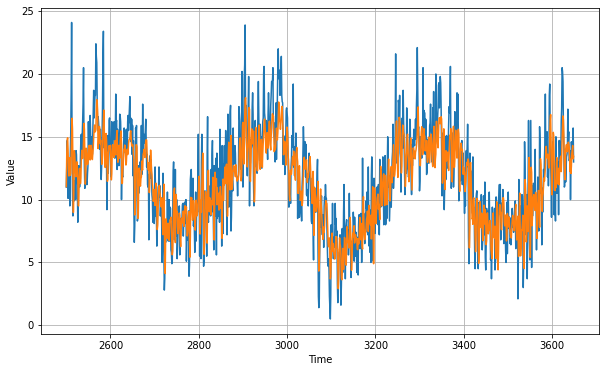

In [32]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [33]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

2.0180717

In [25]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[12.980037 11.968904 11.680199 ... 12.763889 13.089593 13.569787]
